# Introduction
The beginning of fluid dynamics has started in acient Greece, when Archimedes investigated the fluid statics and bouancy. From that time, many well-konwn mathematicians and engineers have contributed to defining how air and gases behave. The equations they have constructed are extremely complex and difficult to calculate by hand when the geometry of airfoil is complicated. The rapid improvement of computers' power in 1970s has led to developing complex flow desings. Over the past few decades CFD has been improved dramatically. 

There are many methods, that are used in Computational Fluid Dynamics. Some of them are Finite Element Method (FEM), Volume of Fluid (VOF) and Lattice Boltzmann Method (LBM). They provide good and accurate results but require high amount of computational resources. To overcome this problem, low fidelity tools can be used, like Vortex Lattice Method (VLM). Using VLM is benefical in the early conceptual design phase, when many different desings should be tested. Thanks to fast computations of aerodynamics forces and pressures, engineers can quickly overview modelled design performance.

# pySailingVLM
In this work, we present the first open source Python package which implements Vortex Lattice Method for initial aerodynamic analysis of upwind sails. Thanks to its light weight requirements, the software can be immediately installed and execude locally or accessed by cloud environment such as Google Collab.

---

# Example
In cell below insert your initial parameters. If some of them are not required for your model, simply pass 0 value (for numbers). 
Some parameters are necessary only for specific cases like roughness (used by package when logarithmic profile is set) and they are omitted during computation. 

<div class="alert alert-block alert-warning"><b>ATTENTION:</b> do not delete keys in dictionaries and do not change their names. 
<br>
Make sure also that the length of your arrays match, like:  girths and chords</div>

More information can be found in code comments below.

In [1]:
# varaibles.py for jupyter
import os
import numpy as np
import time
from pySailingVLM.runner.container import Output, Rig, Conditions, Solver, MainSail, JibSail, Csys, Keel

mgirths =  np.array([0.00, 1./8, 1./4, 1./2, 3./4, 7./8, 1.00])
jgirths = np.array([0.00, 1./4, 1./2, 3./4, 1.00])


out = Output(case_name='my_case_name',
             case_dir=os.path.abspath(''),
             name=os.path.join("results_example_jib_and_mainsail_vlm", time.strftime("%Y-%m-%d_%Hh%Mm%Ss")),
             file_name='my_file_name')

solver = Solver(n_spanwise=10,
                n_chordwise=5,
                interpolation_type='spline')

conditions = Conditions(leeway_deg=5.,    
                        heel_deg=10.,    
                        SOG_yacht=4.63,  
                        tws_ref= 4.63,     
                        alpha_true_wind_deg= 50., 
                        reference_water_level_for_wind_profile=-0.,
                        wind_exp_coeff=0.1428,
                        wind_reference_measurment_height=10.,
                        rho=1.225,
                        wind_profile='exponential',
                        roughness=0.05)


rig = Rig(main_sail_luff=12.4,
          jib_luff=10.0,
          foretriangle_height=11.50,
          foretriangle_base=3.90,
          sheer_above_waterline=1.2,
          boom_above_sheer=1.3,
          rake_deg=92.,
          mast_LOA=0.15,
          sails_def='jib_and_main')

main = MainSail(centerline_twist_deg=None,
                girths=np.array([0.00, 1./8, 1./4, 1./2, 3./4, 7./8, 1.00]),
                chords=np.array([4.00, 3.82, 3.64, 3.20, 2.64, 2.32, 2.00]),
                camber=5*np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
                camber_distance_from_luff=np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))

jib = JibSail(centerline_twist_deg=None,
             girths=np.array([0.00, 1./4, 1./2, 3./4, 1.00]),
             chords=np.array([3.80, 2.98, 2.15, 1.33, 0.5]),
             camber=0*np.array([0.01, 0.01, 0.01, 0.01, 0.01]),
             camber_distance_from_luff=np.array([0.5, 0.5, 0.5, 0.5, 0.5]))

csys = Csys(reference_level_for_moments=np.array([0, 0, 0]))
keel = Keel(center_of_lateral_resistance_upright=np.array([0, 0, -1.0]))


<div class="alert alert-block alert-warning">
<b>Run cell below twice:</b> Run cell below twice before running other cells. Output below is expected to always appear at first time importing pySailingVLM:
<br><br>
    
<em>   
/home/user/miniconda3/envs/mgr_test/lib/python3.10/site-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x7f01d6a1e9e0 at 0x7f01d6cfa680>. Debug line information may be inaccurate.warnings.warn(NumbaDebugInfoWarning(msg))
</em> 
<br>
</div>

In [2]:
import shutil
from pySailingVLM.rotations.csys_transformations import CSYS_transformations
from pySailingVLM.yacht_geometry.hull_geometry import HullGeometry
from pySailingVLM.results.save_utils import save_results_to_file
from pySailingVLM.solver.panels_plotter import display_panels_xyz_and_winds
from pySailingVLM.results.inviscid_flow import InviscidFlowResults
from pySailingVLM.solver.vlm import Vlm
from pySailingVLM.runner.sail import Wind, Sail
from pySailingVLM.solver.panels_plotter import plot_cp

In [3]:
csys_transformations = CSYS_transformations(
    conditions.heel_deg, conditions.leeway_deg,
    v_from_original_xyz_2_reference_csys_xyz=csys.reference_level_for_moments)


w = Wind(conditions)
s = Sail(solver, rig, main, jib, csys_transformations)
sail_set = s.sail_set
hull = HullGeometry(rig.sheer_above_waterline, rig.foretriangle_base, csys_transformations, keel.center_of_lateral_resistance_upright)
myvlm = Vlm(sail_set.panels, solver.n_chordwise, solver.n_spanwise, conditions.rho, w.profile, sail_set.trailing_edge_info, sail_set.leading_edge_info)

inviscid_flow_results = InviscidFlowResults(sail_set, csys_transformations, myvlm)
inviscid_flow_results.estimate_heeling_moment_from_keel(hull.center_of_lateral_resistance)

Cell below displays computations and saves integrals to output file.
<div class="alert alert-block alert-info">
<b>Tip:</b> For proper rendering of matplotlib figures in jupyter notebooks insert <em>%matplotlib widget</em> before calling plot functions.
</div>

Preparing visualization.


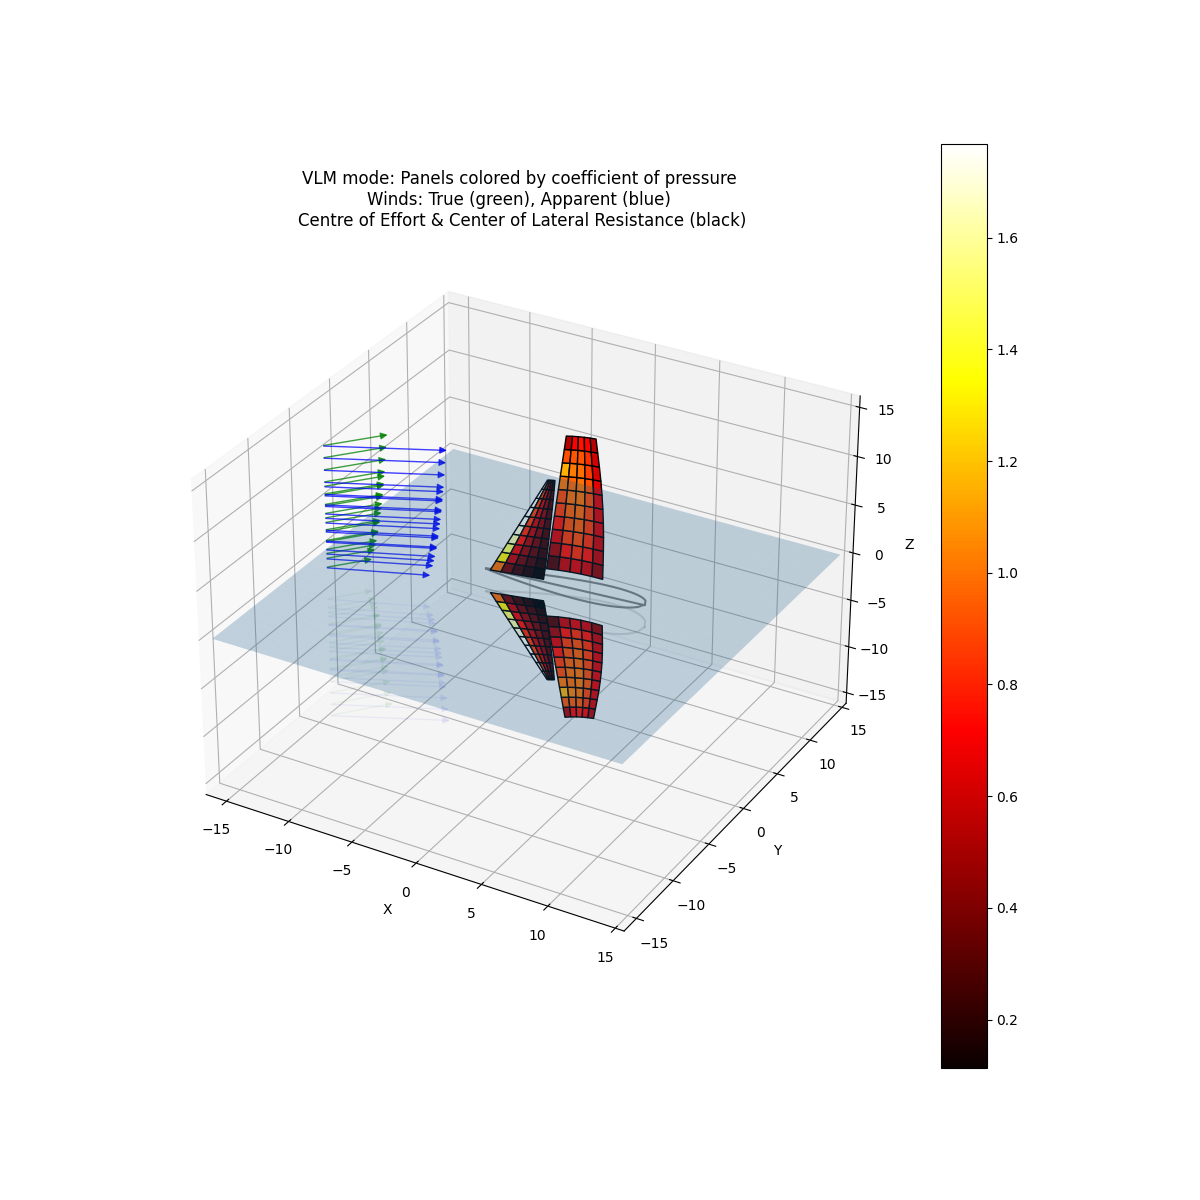

In [4]:
%matplotlib widget
print("Preparing visualization.")   
display_panels_xyz_and_winds(myvlm, inviscid_flow_results, myvlm.inlet_conditions, hull, show_plot=True) # add show_apparent_induced_wind=True for apparent + induced wind 
df_components, df_integrals, df_inlet_IC = save_results_to_file(myvlm, csys_transformations, inviscid_flow_results, s.sail_set, out.name, out.file_name)

Lets see our integrals :)

In [5]:
print(f"-------------------------------------------------------------")
print(f"Notice:\n"
  f"\tThe forces [N] and moments [Nm] are without profile drag.\n"
  f"\tThe the _COG_ CSYS is aligned in the direction of the yacht movement (course over ground).\n"
  f"\tThe the _COW_ CSYS is aligned along the centerline of the yacht (course over water).\n"
  f"\tNumber of panels (sail s.sail_set with mirror): {s.sail_set.panels.shape}")

df_integrals

-------------------------------------------------------------
Notice:
	The forces [N] and moments [Nm] are without profile drag.
	The the _COG_ CSYS is aligned in the direction of the yacht movement (course over ground).
	The the _COW_ CSYS is aligned along the centerline of the yacht (course over water).
	Number of panels (sail s.sail_set with mirror): (200, 4, 3)


,Quantity,Value
0,F_jib_total_COG.x,-202.265193
1,F_jib_total_COG.y,463.058278
2,F_jib_total_COG.z,-33.136625
3,F_main_sail_total_COG.x,-399.385144
4,F_main_sail_total_COG.y,1152.557561
5,F_main_sail_total_COG.z,-219.865275
6,F_sails_total_COG.x,-601.650337
7,F_sails_total_COG.y,1615.615839
8,F_sails_total_COG.z,-253.001900
9,F_sails_total_COW.x,-740.171074


Compute aerodynamic parameters:

In [6]:
sails_Cxyz = myvlm.get_Cxyz(w, 1.0)
print(f"Cxyz for {rig.sails_def}")
for idx, c in enumerate(sails_Cxyz):
    print(f"C[{idx}]: {c}")

Cxyz for jib_and_main
C[0]: [-1.47357985  3.37355795 -0.24141308]
C[1]: [-1.50653888  4.34761484 -0.82936381]


Make model plot in 2D colored by pressure coefficients:

In [7]:
from pySailingVLM.solver.panels_plotter import plot_cp
plot_cp(sail_set.zero_mesh, myvlm.p_coeffs, out.name)

Loading BokehJS ...

In [10]:
from pySailingVLM.solver.coefs import get_C
cl = get_C(myvlm.panels, myvlm.areas, myvlm.lift, myvlm.inlet_conditions.V_app_infs, myvlm.n_spanwise, myvlm.n_chordwise, myvlm.rho)
cd = get_C(myvlm.panels, myvlm.areas, myvlm.drag, myvlm.inlet_conditions.V_app_infs, myvlm.n_spanwise, myvlm.n_chordwise, myvlm.rho)

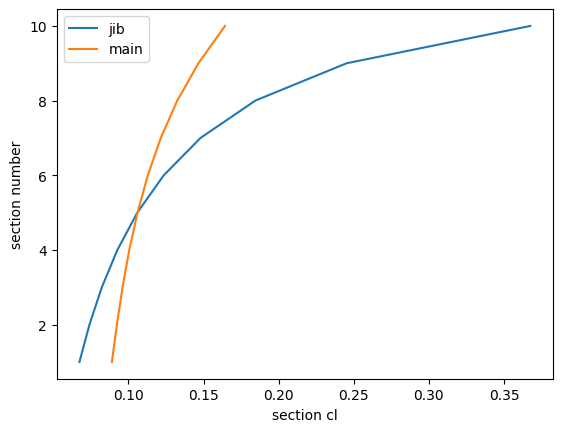

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
section_number = np.arange(1, myvlm.n_spanwise+1, 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(cl[0], section_number, label='jib')
ax1.plot(cl[1], section_number, label='main')
plt.ylabel('section number')
plt.xlabel('section cl')
plt.legend(loc='upper left')
plt.show()

Thats all. Experiment and play with this code on your own.

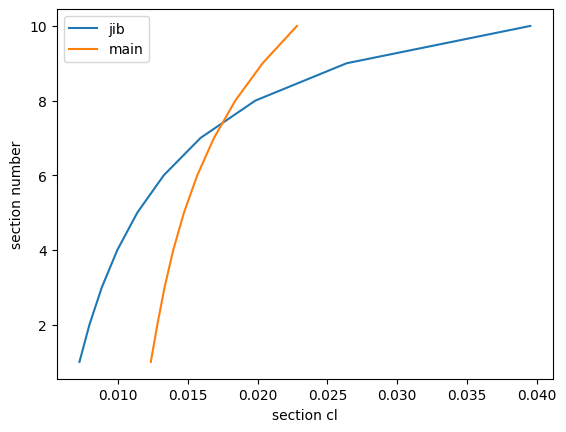

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
section_number = np.arange(1, myvlm.n_spanwise+1, 1)

fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(cd[0], section_number, label='jib')
ax1.plot(cd[1], section_number, label='main')
plt.ylabel('section number')
plt.xlabel('section cl')
plt.legend(loc='upper left')
plt.show()